<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/4-improving-accuracy-with-fine-tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/4-improving-accuracy-with-fine-tuning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 4 - Building a Reverse Image Search Engine: Understanding Embeddings](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html).

Note: In order to run this notebook on Google Colab you need to [follow these instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC) so that the local data such as the images are available in your Google Drive.

# Improving accuracy with Fine-Tuning


Many of the pre-trained models were trained on the ImageNet dataset. Therefore, they provide an incredible starting point for similarity computations in most situations. That said, if you tune these models to adapt to your specific problem, they would perform even more accurately for finding similar images. 

In this portion of the chapter, we will find the least accurate (worst) performing categories, visualize them with t-SNE, fine-tune and then see how their t-SNE graph changes.

In [1]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
from textwrap import wrap

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

We utilize the helper functions we used before in previous notebooks here as well

In [2]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]

Helper function to display accuracy stats and plot similar images

In [3]:
def display(dic, per_class, neighbors, message):
    for key in dic:
        print(key, "\tAccuracy: ", per_class[key])
    for each_class in dic:
        indices_of_class = [
            i for i, j in enumerate(filenames) if classname(j) == each_class
        ]
        random_image_index = random.choice(indices_of_class)
        distances, indices = neighbors.kneighbors(
            [feature_list[random_image_index]])
        similar_image_paths = [filenames[random_image_index]] + \
            [filenames[indices[0][i]] for i in range(1, 4)]
        plot_images(similar_image_paths, distances[0], message)

Helper function that calculates accuracy using the Nearest Neighbours Brute force algorithm and returns the classes that the model performed least accurately on

In [4]:
def get_least_accurate_classes(feature_list):
    per_class_acc = {}
    num_nearest_neighbors = 5
    num_correct_predictions = 0
    num_incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            predicted_class = classname(filenames[indices[0][j]])
            ground_truth = classname(filenames[i])
            if (predicted_class not in per_class_acc):
                per_class_acc[predicted_class] = [0, 0, 0]
            if ground_truth == predicted_class:
                num_correct_predictions += 1
                per_class_acc[predicted_class][0] += 1
                per_class_acc[predicted_class][2] += 1
            else:
                num_incorrect_predictions += 1
                per_class_acc[predicted_class][1] += 1
                per_class_acc[predicted_class][2] += 1
    print(
        "Accuracy is ",
        round(
            100.0 * num_correct_predictions /
            (1.0 * num_correct_predictions + num_incorrect_predictions), 2))
    for key, value in per_class_acc.items():
        per_class_acc[key] = round(100.0 * value[0] / (1.0 * value[2]), 2)
    dic = sorted(per_class_acc, key=per_class_acc.get)

    # least_accurate classes
    print("\n\nTop 10 incorrect classifications\n")
    for key in dic[:10]:
        print(key, "\tAccuracy: ", per_class_acc[key])
    return dic[:6], per_class_acc

Load the features of the Caltech256 dataset to run our experiments on

In [5]:
# Load dataset features
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

Train the PCA model on the loaded features.

In [6]:
# Perform PCA over the features
# set the number of features intended
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list = pca.transform(feature_list)


Note: We are using the classes with the least accuracy because the effect of finetuning is expected be most pronounced on these categories. 

In [7]:
names_of_least_accurate_classes_before_finetuning, accuracy_per_class_before_finetuning = get_least_accurate_classes(
    feature_list[:])

C:\Users\Asus\AppData\Local\Temp\ipykernel_19588\884831488.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(feature_list))):


  0%|          | 0/8677 [00:00<?, ?it/s]

Accuracy is  100.0


Top 10 incorrect classifications

caltech101 	Accuracy:  100.0


Print names of the least accurate classes before fine-tuning

In [8]:
names_of_least_accurate_classes_before_finetuning

['caltech101']

Combine the features from the 6 least accurate classes into a list so that we can use this list for further experiments and visualization. 

In [9]:
least_accurate_feature_list = []
least_accurate_filenames = []
least_accurate_count = {}
for index, filename in enumerate(filenames):
    if classname(filename) not in least_accurate_count:
        least_accurate_count[classname(filename)] = 0
    if classname(
            filename
    ) in names_of_least_accurate_classes_before_finetuning and least_accurate_count[
            classname(filename)] <= 50:
        least_accurate_feature_list.append(feature_list[index])
        least_accurate_count[classname(filename)] += 1
        least_accurate_filenames.append(class_ids[index])

Train t-SNE only on the 6 least accurate classes.

In [10]:
from sklearn.manifold import TSNE
selected_features = np.array(least_accurate_feature_list)
selected_class_ids = least_accurate_filenames
selected_filenames = least_accurate_filenames
time_start = time.time()
tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(selected_features)
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250, metric=’euclidean’)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 50 nearest neighbors...
[t-SNE] Indexed 51 samples in 0.001s...
[t-SNE] Computed neighbors for 51 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 51 / 51
[t-SNE] Mean sigma: 0.216092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.020035
[t-SNE] KL divergence after 900 iterations: 0.088265
t-SNE done! Time elapsed: 0.20611882209777832 seconds


### t-SNE visualization of feature vectors of least accurate classes before finetuning

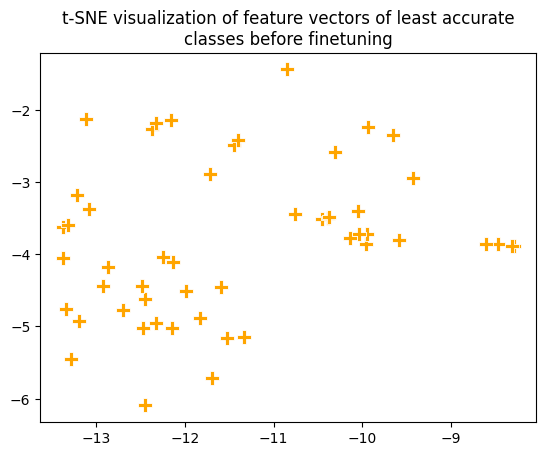

In [11]:
plt.title("\n".join(
    wrap(
        "t-SNE visualization of feature vectors of least accurate classes before finetuning",
        60)))
set_classes = list(set(selected_class_ids))
# set different markers for all the classes we are going to show
markers = ["^", ".", "s", "o", "x", "P"]
# set different colors for all the classes we are going to show
colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
class_to_marker = {}
class_to_color = {}
for index in range(len(tsne_results)):
    # assign color and marker to each type of class
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()
    plt.scatter(tsne_results[index, 0],
                tsne_results[index, 1],
                c=class_to_color[selected_class_ids[index]],
                marker=class_to_marker[selected_class_ids[index]],
                edgecolor='white',
                linewidth=.6,
                s=90)
plt.show()

These feature vectors are all over the place! Using these feature vectors in other applications such as classification might not be a good idea as it would be difficult to find a plane of separation between them. 


Read the finetuned features from the Caltech-256 dataset 

In [12]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet-finetuned.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

In [13]:
# Perform PCA over the features
# set the number of features intended
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list = pca.transform(feature_list)

Combine the features from the 6 least accurate classes into a list so that we can use this list for further experiments and visualization. Note that we are using the same categories (`names_of_least_accurate_classes_before_finetuning`) as before to enable an apples-to-apples comparison.

In [14]:
least_accurate_feature_list = []
least_accurate_filenames = []
least_accurate_count = {}
for index, filename in enumerate(filenames):
    if classname(filename) not in least_accurate_count:
        least_accurate_count[classname(filename)] = 0
    if classname(
            filename
    ) in names_of_least_accurate_classes_before_finetuning and least_accurate_count[
            classname(filename)] <= 50:
        least_accurate_feature_list.append(feature_list[index])
        least_accurate_count[classname(filename)] += 1
        least_accurate_filenames.append(class_ids[index])

Train a t-SNE model using the 

In [15]:
from sklearn.manifold import TSNE
selected_features = np.array(least_accurate_feature_list)
selected_class_ids = least_accurate_filenames
selected_filenames = least_accurate_filenames
time_start = time.time()
tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(selected_features)
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250, metric=’euclidean’)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 50 nearest neighbors...
[t-SNE] Indexed 51 samples in 0.000s...
[t-SNE] Computed neighbors for 51 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 51 / 51
[t-SNE] Mean sigma: 0.002172
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.000607
[t-SNE] KL divergence after 800 iterations: 0.016933
t-SNE done! Time elapsed: 0.14757752418518066 seconds


### t-SNE visualization of feature vectors of least accurate classes after finetuning

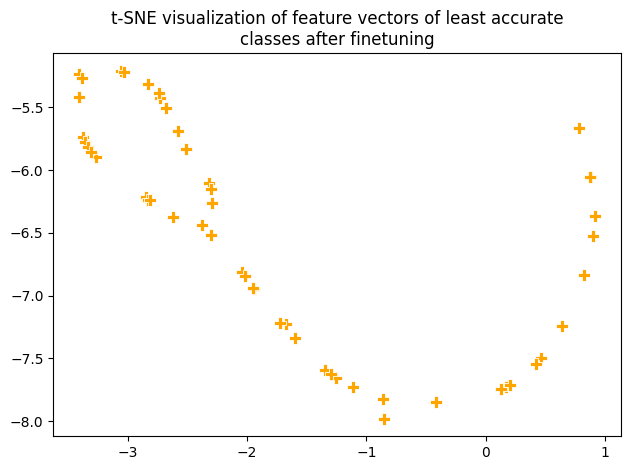

In [16]:
plt.title("\n".join(
    wrap(
        "t-SNE visualization of feature vectors of least accurate classes after finetuning",
        60)))
plt.tight_layout()
set_classes = list(set(selected_class_ids))
markers = ["^", ".", "s", "o", "x", "P"]
colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
class_to_marker = {}
class_to_color = {}
for index in range(len(tsne_results)):
    # get only those tsne_results which belong to each_class
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()
    scatterPlot = plt.scatter(
        tsne_results[index, 0],
        tsne_results[index, 1],
        c=class_to_color[selected_class_ids[index]],
        marker=class_to_marker[selected_class_ids[index]],
        edgecolor='white',
        linewidth=.6,
        s=80)
plt.show()

This is so much cleaner. With just a little bit of fine tuning as shown in chapter 2, the embeddings start to group together. Compare the noisy/scattered embeddings of the pre-trained models against those of the fine-tuned model. A machine learning classifier would be able to find a plane of separation between these classes with much more ease, hence giving better classification accuracy as well as more similar images when not using a classifier. And, remember, these were the classes with the highest misclassifications, imagine how nicely the classes with originally higher accuracy would be after fine-tuning.
